In [1]:
# https://github.com/ray-project/ray/blob/master/rllib/examples/sb2rllib_rllib_example.py
import ray
from ray import tune, air
import ray.rllib.algorithms.ppo as ppo
from IPython.display import display, clear_output
from time import sleep
from glob import glob
from pathlib import Path
from tqdm import tqdm
from itertools import count
import matplotlib.pyplot as plt

In [2]:
if ray.is_initialized():
    ray.shutdown()
ray.init(num_gpus=1, local_mode=False)

Usage stats collection is enabled by default for nightly wheels. To disable this, run the following command: `ray disable-usage-stats` before starting Ray. See https://docs.ray.io/en/master/cluster/usage-stats.html for more details.


2023-02-24 15:11:44,596	INFO worker.py:1536 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.8.15
Ray version:,3.0.0.dev0
Dashboard:,http://127.0.0.1:8265


In [3]:
# env config
import gymnasium as gym
import platoonenv

env_name = "Platoon-v6"
env_config=dict(
    num_vehicles=10,
    steps_before_truncation=200,
    cycle_interval=2,
    attack_interval=1,
    cycle_num=1,
)
env = gym.make(
    id=env_name,
    render_mode="canvas",
    env_config=env_config,
)

print(env_name,"\n------------------")
print("reward_threshold", env.spec.reward_threshold)
print("max_episode_steps", env.spec.max_episode_steps)

Platoon-v6 
------------------
reward_threshold None
max_episode_steps None


In [4]:
from ray.rllib.utils import check_env

check_env(env)

2023-02-24 15:11:47,740	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.


In [5]:
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.dqn import DQNConfig
from ray.rllib.algorithms.random_agent import RandomAgentConfig

ppo_config = (
    PPOConfig()
    .environment(env=env_name, env_config=env_config)
    .framework("torch")
    .rollouts(num_rollout_workers=3)
    .resources(num_gpus=1, num_cpus_for_local_worker=0.5)
)

ppo_config.horizon = env.spec.max_episode_steps
ppo_config.create_env_on_local_worker=True

dqn_config = (
    DQNConfig()
    .environment(env=env_name, env_config=env_config)
    .framework("torch")
    .rollouts(num_rollout_workers=3)
    .resources(num_gpus=0.5, num_cpus_for_local_worker=0.5)
)
dqn_config.horizon = env.spec.max_episode_steps
dqn_config.create_env_on_local_worker=True

random_config = (
    RandomAgentConfig()
    .environment(env=env_name, env_config=env_config)
    .framework("torch")
    .rollouts(num_rollout_workers=3)
    .resources(num_gpus=0.5, num_cpus_for_local_worker=0.5)
)
random_config.horizon = env.spec.max_episode_steps
random_config.create_env_on_local_worker=True

In [6]:
ppo_algo = ppo_config.build()

(RolloutWorker pid=12676) 2023-02-24 15:11:56,522	INFO policy.py:1196 -- Policy (worker=3) running on CPU.
(RolloutWorker pid=12676) 2023-02-24 15:11:56,522	INFO torch_policy_v2.py:110 -- Found 1 visible cuda devices.
(RolloutWorker pid=11728) 2023-02-24 15:11:56,568	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
2023-02-24 15:11:56,690	INFO policy.py:1196 -- Policy (worker=local) running on 1 GPUs.
2023-02-24 15:11:56,691	INFO torch_policy_v2.py:110 -- Found 1 visible cuda devices.
(RolloutWorker pid=16912) 2023-02-24 15:11:56,624	INFO policy.py:1196 -- Policy (worker=2) running on CPU.
(RolloutWorker pid=16912) 2023-02-24 15:11:56,624	INFO torch_policy_v2.py:110 -- Found 1 visible cuda devices.
(RolloutWorker pid=11728) 2023-02-24 15:11:56,609	INFO policy.py:1196 -- Policy (worker=1) running on 

In [7]:
!ray status

======== Autoscaler status: 2023-02-24 15:11:58.855695 ========
Node status
---------------------------------------------------------------
Healthy:
 1 node_b0ecc143a24582c660ca0cc0026e59ebf3539e4144de9cfa728b0c89
Pending:
 (no pending nodes)
Recent failures:
 (no failures)

Resources
---------------------------------------------------------------
Usage:
 3.0/12.0 CPU
 0.0/1.0 GPU
 0.0/1.0 accelerator_type:G
 0.00/11.348 GiB memory
 0.00/5.674 GiB object_store_memory

Demands:
 (no resource demands)


In [8]:
dqn_algo = dqn_config.build()

(RolloutWorker pid=13840) 2023-02-24 15:12:10,125	INFO policy.py:1196 -- Policy (worker=3) running on CPU.
(RolloutWorker pid=13840) 2023-02-24 15:12:10,125	INFO torch_policy.py:184 -- Found 1 visible cuda devices.
(RolloutWorker pid=24124) 2023-02-24 15:12:10,046	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
(RolloutWorker pid=24124) 2023-02-24 15:12:10,125	INFO policy.py:1196 -- Policy (worker=1) running on CPU.
(RolloutWorker pid=24124) 2023-02-24 15:12:10,126	INFO torch_policy.py:184 -- Found 1 visible cuda devices.
(RolloutWorker pid=13984) 2023-02-24 15:12:10,127	INFO policy.py:1196 -- Policy (worker=2) running on CPU.
(RolloutWorker pid=13984) 2023-02-24 15:12:10,127	INFO torch_policy.py:184 -- Found 1 visible cuda devices.
2023-02-24 15:12:10,157	INFO policy.py:1196 -- Policy (worker=loca

In [9]:
!ray status

======== Autoscaler status: 2023-02-24 15:12:08.885730 ========
Node status
---------------------------------------------------------------
Healthy:
 1 node_b0ecc143a24582c660ca0cc0026e59ebf3539e4144de9cfa728b0c89
Pending:
 (no pending nodes)
Recent failures:
 (no failures)

Resources
---------------------------------------------------------------
Usage:
 6.0/12.0 CPU
 0.0/1.0 GPU
 0.0/1.0 accelerator_type:G
 0.00/11.348 GiB memory
 0.00/5.674 GiB object_store_memory

Demands:
 (no resource demands)


In [10]:
random_algo = random_config.build()

In [11]:
!ray status

======== Autoscaler status: 2023-02-24 15:12:13.901561 ========
Node status
---------------------------------------------------------------
Healthy:
 1 node_b0ecc143a24582c660ca0cc0026e59ebf3539e4144de9cfa728b0c89
Pending:
 (no pending nodes)
Recent failures:
 (no failures)

Resources
---------------------------------------------------------------
Usage:
 6.0/12.0 CPU
 0.0/1.0 GPU
 0.0/1.0 accelerator_type:G
 0.00/11.348 GiB memory
 0.00/5.674 GiB object_store_memory

Demands:
 (no resource demands)


In [12]:
checkpoints = sorted(glob(str(Path("saved_models","**","checkpoint_*"))))

In [13]:
import ipywidgets as widgets

In [14]:
suffix = "newreward"

In [15]:
ppo_save_dir = Path("saved_models",f"{env_name}-{str(ppo_algo)}-{env_config['num_vehicles']}vehicles-{suffix}")
ppo_save_dir.mkdir(parents=True, exist_ok=True)
print(ppo_save_dir)

ppo_checkpoint_path = sorted(glob(str(ppo_save_dir / "*")))[-1] # grab latest

w = widgets.Dropdown(
    layout={'width': 'initial'},
    options=checkpoints,
    value=ppo_checkpoint_path,
    description='PPO:'
)

def on_change(change):
    global ppo_checkpoint_path
    if change['type'] == 'change' and change['name'] == 'value':
        print("changed to %s" % change['new'])
        ppo_checkpoint_path = change['new']

w.observe(on_change)
display(w)

saved_models\Platoon-v6-PPO-10vehicles-newreward


Dropdown(description='PPO:', index=75, layout=Layout(width='initial'), options=('saved_models\\Platoon-v0-curi…

In [16]:
dqn_save_dir = Path("saved_models",f"{env_name}-{str(dqn_algo)}-{env_config['num_vehicles']}vehicles-{suffix}")
dqn_save_dir.mkdir(parents=True, exist_ok=True)
print(dqn_save_dir)

dqn_checkpoint_path = sorted(glob(str(dqn_save_dir / "*")))[-1] # grab latest

w = widgets.Dropdown(
    layout={'width': 'initial'},
    options=checkpoints,
    value=dqn_checkpoint_path,
    description='DQN:'
)

def on_change(change):
    global dqn_checkpoint_path
    if change['type'] == 'change' and change['name'] == 'value':
        print("changed to %s" % change['new'])
        dqn_checkpoint_path = change['new']

w.observe(on_change)
display(w)

saved_models\Platoon-v6-DQN-10vehicles-newreward


Dropdown(description='DQN:', index=60, layout=Layout(width='initial'), options=('saved_models\\Platoon-v0-curi…

In [17]:
print(f"PPO restoring from checkpoint: {ppo_checkpoint_path}")
ppo_algo.restore(ppo_checkpoint_path)

2023-02-24 15:12:16,098	INFO trainable.py:790 -- Restored on 127.0.0.1 from checkpoint: saved_models\Platoon-v6-PPO-10vehicles-newreward\checkpoint_000320


PPO restoring from checkpoint: saved_models\Platoon-v6-PPO-10vehicles-newreward\checkpoint_000320


2023-02-24 15:12:16,098	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 320, '_timesteps_total': None, '_time_total': 4039.070713043213, '_episodes_total': 6360}


In [18]:
print(f"DQN restoring from checkpoint: {dqn_checkpoint_path}")
dqn_algo.restore(dqn_checkpoint_path)

DQN restoring from checkpoint: saved_models\Platoon-v6-DQN-10vehicles-newreward\checkpoint_000597


2023-02-24 15:12:16,238	INFO trainable.py:790 -- Restored on 127.0.0.1 from checkpoint: saved_models\Platoon-v6-DQN-10vehicles-newreward\checkpoint_000597
2023-02-24 15:12:16,239	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 597, '_timesteps_total': None, '_time_total': 4011.4212489128113, '_episodes_total': 2970}


In [19]:
{
    "ppo":{k:v for k,v in ppo_algo.get_state().items() if k != "last_result"},
    "dqn": {k:v for k,v in dqn_algo.get_state().items() if k != "last_result"},
}

{'ppo': {'experiment_id': 'cb2de83cf64945bfb69e009c2dd340f0',
  'iteration': 320,
  'timesteps_total': None,
  'time_total': 4039.070713043213,
  'episodes_total': 6360,
  'ray_version': '3.0.0.dev0'},
 'dqn': {'experiment_id': '3662aae156ee4bef8c3477041f40b823',
  'iteration': 597,
  'timesteps_total': None,
  'time_total': 4011.4212489128113,
  'episodes_total': 2970,
  'ray_version': '3.0.0.dev0'}}

In [20]:
# iter = dqn_algo.get_state()["iteration"]
# assert dqn_algo.get_state()["iteration"] == ppo_algo.get_state()["iteration"]

In [21]:
import numpy as np

In [22]:
%matplotlib ipympl

In [23]:
env = gym.make(
    id=env_name,
    render_mode="canvas",
    env_config={
        **env_config,
        "steps_before_truncation": 200
    },
)

In [24]:
# find the first index of a zero and add 1, or return 0 otherwise
def find_first_zero(x):
    try:
        return np.where(x==0)[0][0] + 1
    except IndexError:
        return 0

In [25]:
policies = {
    "PPO": lambda obs, info: ppo_algo.compute_single_action(obs, explore=True),
    "DQN": lambda obs, info: dqn_algo.compute_single_action(obs, explore=True),
    "random": lambda obs, info: env.action_space.sample(),
    "no-op": lambda obs, info: 0,
    "grow": lambda obs, info: find_first_zero(info["state"]),
}

In [26]:
results = {}

In [27]:
num_episodes = 10
with tqdm(total=env_config["steps_before_truncation"]*len(policies)*num_episodes) as pbar:
    for policy_name, policy in policies.items():
        pbar.set_description(policy_name)
        actions = []
        rewards = []
        observations = []
        for episode in range(num_episodes):
            obs, info = env.reset(seed=episode+num_episodes)
            observations.append((obs,info))
            for episode_step in count():
                pbar.update()
                action = policy(obs, info)
                next_obs, reward, terminated, truncated, info = env.step(action)
                actions.append(action)
                rewards.append(float(reward))
                observations.append((next_obs,info))
                if terminated or truncated:
                    # print(f"trained ended after step {episode_step} with reward {sum(rewards):.2f} (spec: {env.spec.reward_threshold})")
                    break
                obs = next_obs
        results[policy_name] = {
            "actions": actions,
            "rewards": rewards,
            "observations": observations,
        }


grow: : 10050it [00:10, 952.94it/s]                           


In [28]:
# suffix = "iter" + dqn_algo.get_state()["iteration"]
suffix = "newreward"
figure_save_dir = Path("figures", f"{env_name}-{str(dqn_algo)}-{env_config['num_vehicles']}vehicles-{suffix}")
figure_save_dir.mkdir(parents=True, exist_ok=True)
print(f"saving to \"{figure_save_dir}\"")

saving to "figures\Platoon-v6-DQN-10vehicles-newreward"


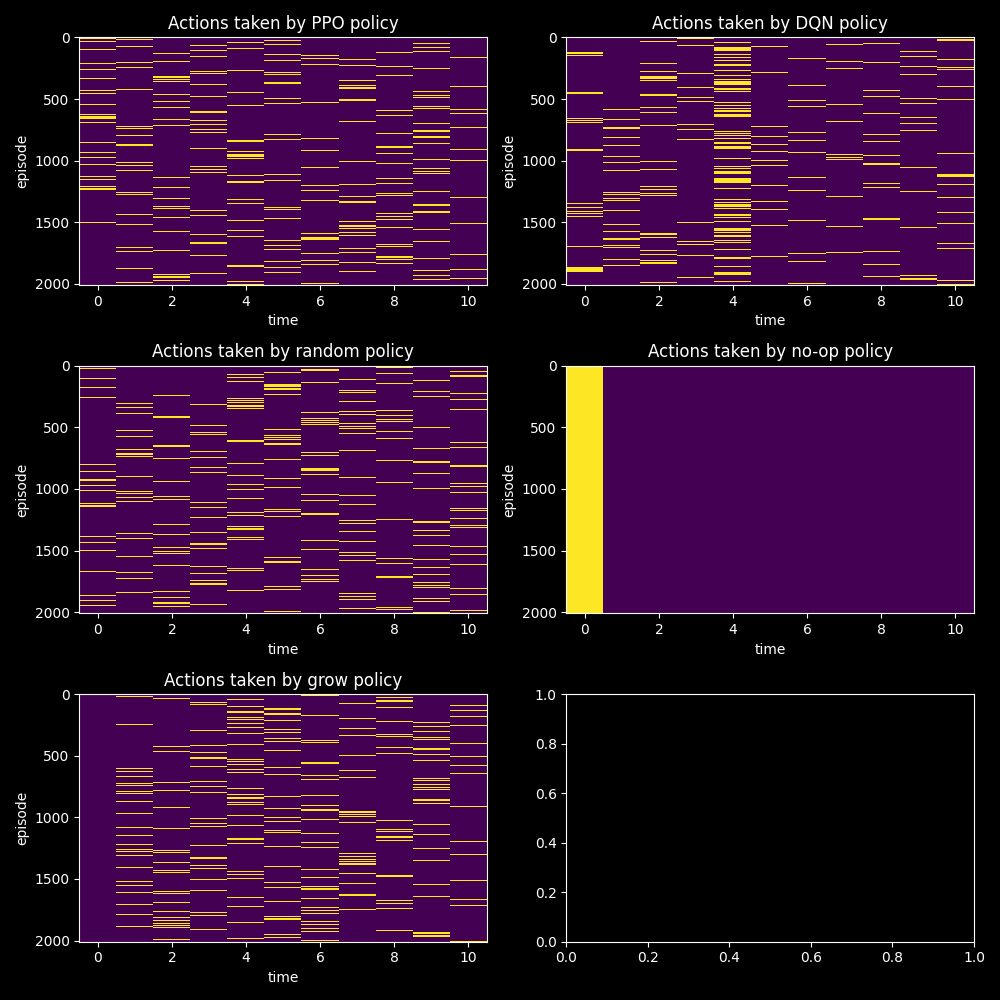

In [29]:
from keras.utils.np_utils import to_categorical
# for policy_name, stats in results.items():
#     plt.figure()
#     plt.title(f"Actions taken by {policy_name} policy")
#     plt.imshow(to_categorical(stats["actions"], num_classes=env.action_space.n), interpolation="nearest", aspect="auto")
#     plt.show()
#     plt.savefig(figure_save_dir / f"actions-{policy_name}.png", format="png")

# or do it with subplots

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,10))
for i, (policy_name, stats) in enumerate(results.items()):
    ax = axes[i//2, i%2]
    ax.set_title(f"Actions taken by {policy_name} policy")
    ax.imshow(to_categorical(stats["actions"], num_classes=env.action_space.n), interpolation="nearest", aspect="auto")
    ax.set_xlabel("time")
    ax.set_ylabel("episode")
plt.tight_layout()
plt.savefig(figure_save_dir / f"actions.png", format="png", dpi=300, bbox_inches="tight")

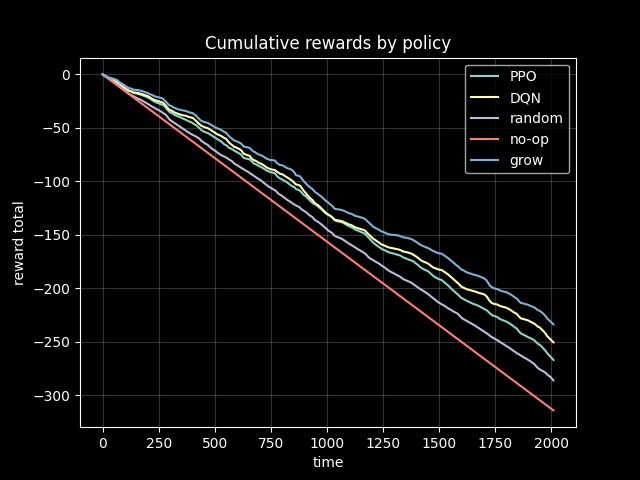

In [30]:
plt.figure()
plt.title("Cumulative rewards by policy")
for policy_name, stats in results.items():
    plt.plot(np.cumsum(stats["rewards"]), label=policy_name)
plt.legend()
plt.xlabel("time")
plt.ylabel("reward total")
plt.grid(True,alpha=0.2)
plt.show()
plt.savefig(figure_save_dir / f"cumulative-rewards.png", format="png")

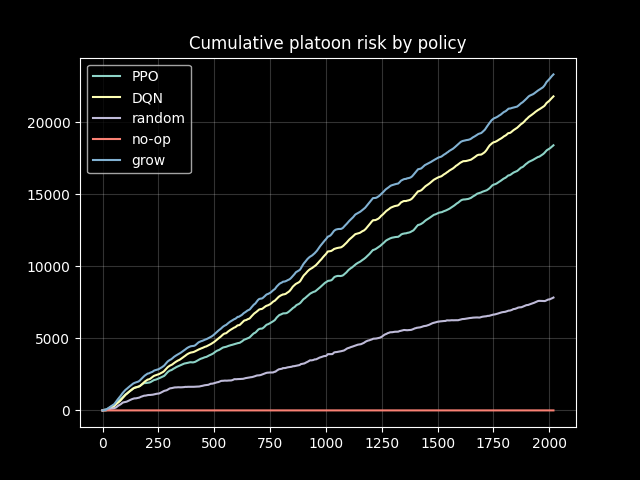

In [31]:
def measure(obs, info):
    # membership = obs[:num_vehicles]
    membership = info["state"][:,None]
    # values = obs[num_vehicles:num_vehicles*2]
    values = info["values"]
    # probs = obs[num_vehicles*2:num_vehicles*3]
    probs = info["probs"]

    return -np.sum(membership * values * probs)
    
plt.figure()
plt.title("Cumulative platoon risk by policy")
for policy_name, stats in results.items():
    plt.plot(np.cumsum([measure(*x) for x in stats["observations"]]), label=policy_name)
# plt.yscale("symlog")
plt.legend()
plt.grid(alpha=0.2)
plt.show()
plt.savefig(figure_save_dir / "cumulative-risk.png", format="png")

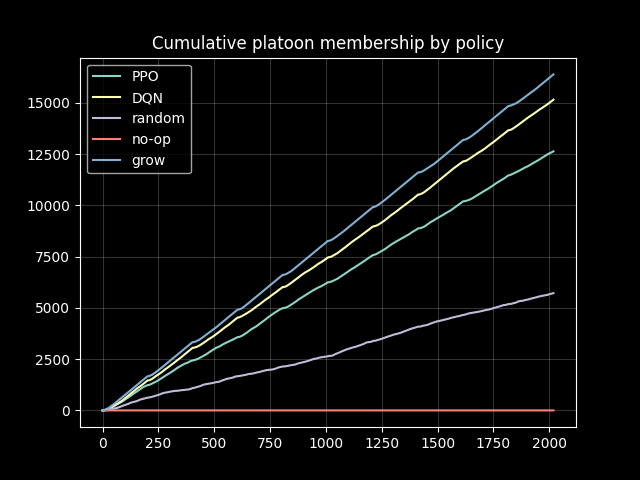

In [32]:
def measure(obs, info):
    membership = info["state"]
    return np.sum(membership)

plt.figure()
plt.title("Cumulative platoon membership by policy")
for policy_name, stats in results.items():
    plt.plot(np.cumsum([measure(*x) for x in stats["observations"]]), label=policy_name)
# plt.yscale("symlog")
plt.legend()
plt.grid(alpha=0.2)
plt.show()
plt.savefig(figure_save_dir / "cumulative-membership.png", format="png")

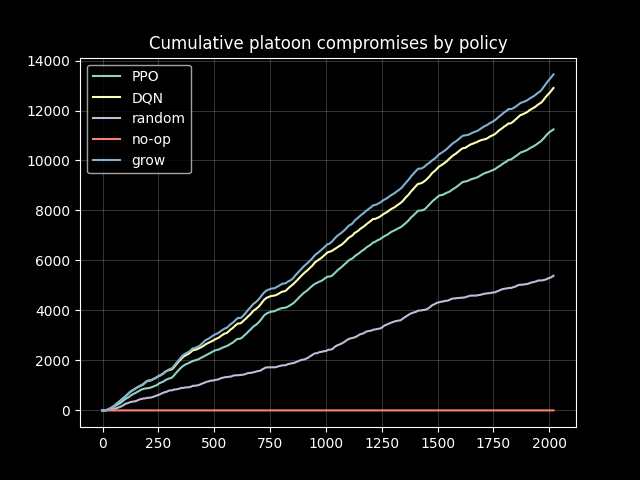

In [33]:
def measure(obs, info):
    # membership = obs[:num_vehicles]
    membership = info["state"][:,None]
    # values = obs[num_vehicles:num_vehicles*2]
    values = info["values"]
    # probs = obs[num_vehicles*2:num_vehicles*3]
    probs = info["probs"]

    return np.sum(membership * (probs == 1))

plt.figure()
plt.title("Cumulative platoon compromises by policy")
for policy_name, stats in results.items():
    plt.plot(np.cumsum([measure(*x) for x in stats["observations"]]), label=policy_name, alpha=1)
# plt.yscale("symlog")
plt.legend()
plt.grid(alpha=0.2)
plt.show()
plt.savefig(figure_save_dir / "cumulative-compromises.png", format="png")

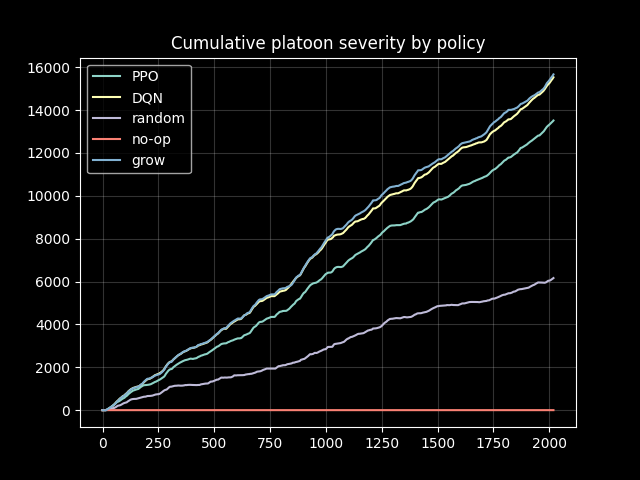

In [34]:
def measure(obs, info):
    # membership = obs[:num_vehicles]
    membership = info["state"][:,None]
    # values = obs[num_vehicles:num_vehicles*2]
    values = info["values"]
    # probs = obs[num_vehicles*2:num_vehicles*3]
    probs = info["probs"]

    return np.sum(membership * (probs == 1) * values * -1)

plt.figure()
plt.title("Cumulative platoon severity by policy")
for policy_name, stats in results.items():
    plt.plot(np.cumsum([measure(*x) for x in stats["observations"]]), label=policy_name, alpha=1)
# plt.yscale("symlog")
plt.legend()
plt.grid(alpha=0.2)
plt.show()
plt.savefig(figure_save_dir / "cumulative-severity.png", format="png")

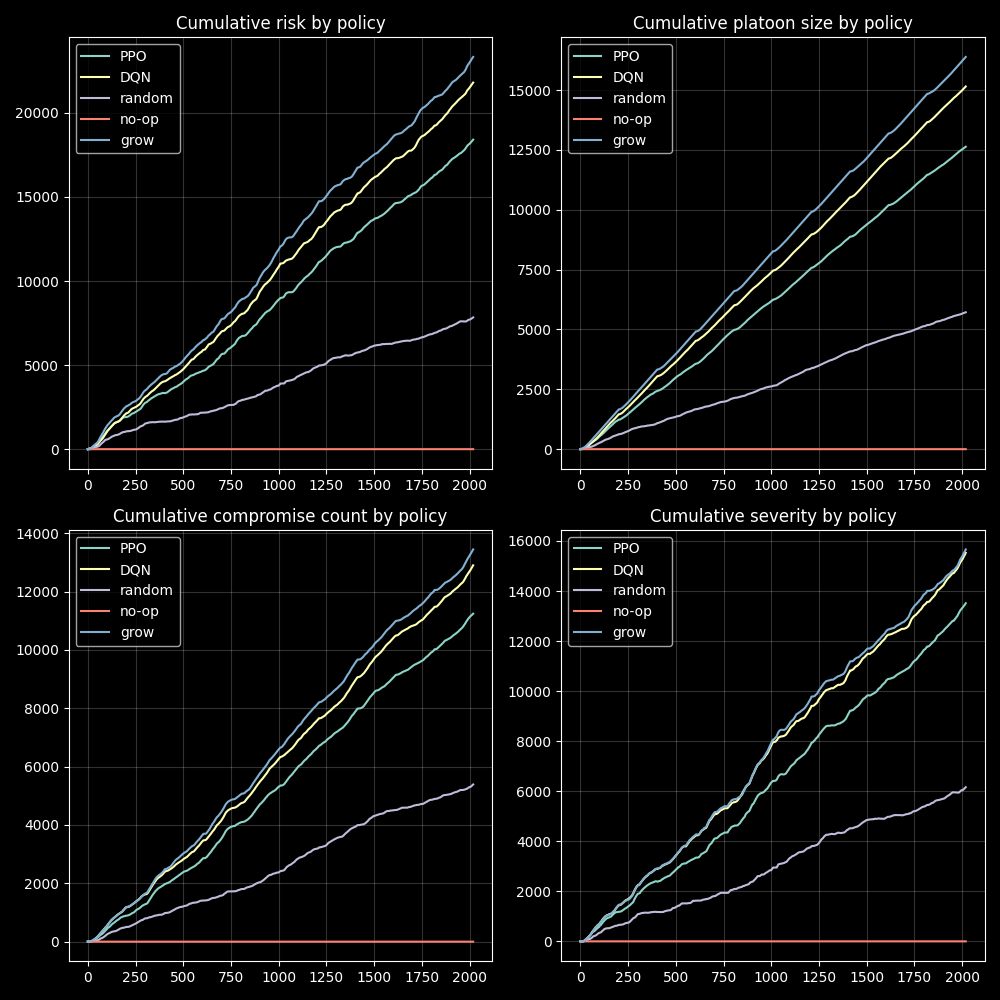

In [35]:
# now do it in a more general way
metrics = {
    "risk": lambda obs, info: -np.sum(info["state"][:,None] * info["values"] * info["probs"]),
    "platoon size": lambda obs, info: np.sum(info["state"]),
    "compromise count": lambda obs, info: np.sum(info["state"][:,None] * (info["probs"] == 1)),
    "severity": lambda obs, info: np.sum(info["state"][:,None] * (info["probs"] == 1) * info["values"] * -1),
}
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
for i, (metric_name, metric) in enumerate(metrics.items()):
    ax = axes[i//2, i%2]
    ax.set_title(f"Cumulative {metric_name} by policy")
    for policy_name, stats in results.items():
        ax.plot(np.cumsum([metric(*x) for x in stats["observations"]]), label=policy_name)
    ax.legend()
    ax.grid(alpha=0.2)
plt.tight_layout()
plt.savefig(figure_save_dir / f"cumulative-metrics.png", format="png", dpi=300, bbox_inches="tight")

In [36]:
table_metrics = {
    "reward": lambda obs, info: np.sum(info["reward"]),
    **metrics,
}
print("policy", end=" & ")
for metric in table_metrics:
    print(metric, end=" & " if metric != list(table_metrics.keys())[-1] else "\\\\")
print("\n\\hline")
for policy, stats in results.items():
    print(policy, end=" & ")
    for metric in table_metrics:
        print(f"{np.mean([table_metrics[metric](*x) for x in stats['observations']]):.3f}", end=" & " if metric != list(table_metrics.keys())[-1] else "\\\\")
    print()

policy & reward & risk & platoon size & compromise count & severity\\
\hline
PPO & -0.132 & 9.111 & 6.255 & 5.566 & 6.689\\
DQN & -0.124 & 10.792 & 7.501 & 6.387 & 7.687\\
random & -0.142 & 3.878 & 2.831 & 2.667 & 3.050\\
no-op & -0.155 & 0.000 & 0.000 & 0.000 & 0.000\\
grow & -0.116 & 11.547 & 8.113 & 6.656 & 7.753\\


In [37]:
print("Mean platoon size")
for policy, stats in results.items():
    platoon_sizes = [sum(info["state"]) for obs, info in stats["observations"]]
    print(f"{policy}: {np.mean(platoon_sizes):.2f}")


Mean platoon size
PPO: 6.26
DQN: 7.50
random: 2.83
no-op: 0.00
grow: 8.11


In [38]:
print("Mean platoon compromises")
for policy, stats in results.items():
    compromises = [sum(info["state"][:,None] * (info["probs"] == 1)) for obs, info in stats["observations"]]
    print(f"{policy}: {np.mean(compromises):.2f}")

Mean platoon compromises
PPO: 1.39
DQN: 1.60
random: 0.67
no-op: 0.00
grow: 1.66


In [39]:
print("Mean platoon severity")
for policy, stats in results.items():
    severity = [sum(info["state"][:,None] * (info["probs"] == 1) * info["values"] * -1) for obs, info in stats["observations"]]
    print(f"{policy}: {np.mean(severity):.2f}")

Mean platoon severity
PPO: 1.67
DQN: 1.92
random: 0.76
no-op: 0.00
grow: 1.94


In [40]:
results["PPO"]["observations"][0][1]

{'action': -1,
 'attacker_action': -1,
 'reward': 0,
 'state': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'values': array([[-3., -2.,  0.,  0.],
        [ 0., -1.,  1.,  1.],
        [-0., -2., -3., -3.],
        [-2., -1.,  0.,  0.],
        [-0., -5., -1.,  0.],
        [-3., -3., -3.,  0.],
        [ 0.,  0., -2.,  0.],
        [ 0.,  0.,  0., -5.],
        [-1.,  0., -1.,  0.],
        [-1.,  0.,  0.,  0.]], dtype=float32),
 'probs': array([[0.33951557, 0.14856873, 0.        , 0.        ],
        [0.        , 0.37326923, 0.63382506, 0.11464436],
        [0.23309048, 0.767241  , 0.98712426, 0.8080011 ],
        [0.84296566, 0.79568267, 0.        , 0.        ],
        [0.578455  , 0.45073557, 0.2710244 , 0.        ],
        [0.06865566, 0.81673443, 0.881835  , 0.4235164 ],
        [0.        , 0.        , 0.5197915 , 0.        ],
        [0.        , 0.33321688, 0.        , 0.45755893],
        [0.67484564, 0.        , 0.5236131 , 0.        ],
        [0.5086

In [41]:
totals = [sum(stats["rewards"]) for stats in results.values()]
best = max(totals)
for (policy_name, stats), total in zip(results.items(), totals):
    steps = env_config["steps_before_truncation"]
    pct = (best-total)/best*100
    print(f"{policy_name}: {total:.2f} ({pct:.2f}%)")

PPO: -267.00 (-14.25%)
DQN: -250.48 (-7.18%)
random: -285.92 (-22.35%)
no-op: -314.06 (-34.39%)
grow: -233.69 (-0.00%)
